# Josiann's parallel mode

In this tutorial, we will explain how to use *Josiann*'s parallel mode for solving similar problems in parallel.
For clarity, we will showcase it on 3 deterministic functions since *Josiann* can also work on non-noisy cost functions.

In [1]:
import plotly.io as pio
pio.renderers.default = "png"

In [2]:
import numpy as np
import plotly.graph_objects as go

import numpy.typing as npt

import josiann as jo

/home/mbouvier/git/josiann/josiann/algorithms/sequential/base/sa.py:9: TqdmExperimentalWarning:

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)



## Defining the problems

We will attempt to find the global minima of 3 functions in parallel. Each have a different minimum location but can
be computed from the same cost function.

Indeed, the parallel mode still only accepts a *single* cost function, which can be parametrized to define multiple
problems. Let's look at this function:

In [3]:
def cost(x: npt.NDArray[np.float64], d: npt.NDArray[np.float64]) -> npt.NDArray[np.float64]:
    return 0.6 + np.sum(
        np.sin(1 - 16 / 15 * x) ** (d + 1)
        - 1 / 50 * np.sin(4 - 64 / 15 * x) ** d
        - np.sin(1 - 16 / 15 * x) ** d
    )

With 3 different values of d (0, 1, 2), we obtain different cost functions (in 2D space) with global minima at
positions (1, 1) (0.47, 0.47) and (0.31, 0.31) respectively.

In [4]:
d_1, d_2, d_3 = 0, 1, 2

X = np.linspace(-1, 1, 100)
Y = np.linspace(-1, 1, 100)

xv, yv = np.meshgrid(X, Y)
coords = np.concatenate((xv.flatten()[:, None], yv.flatten()[:, None]), axis=1)

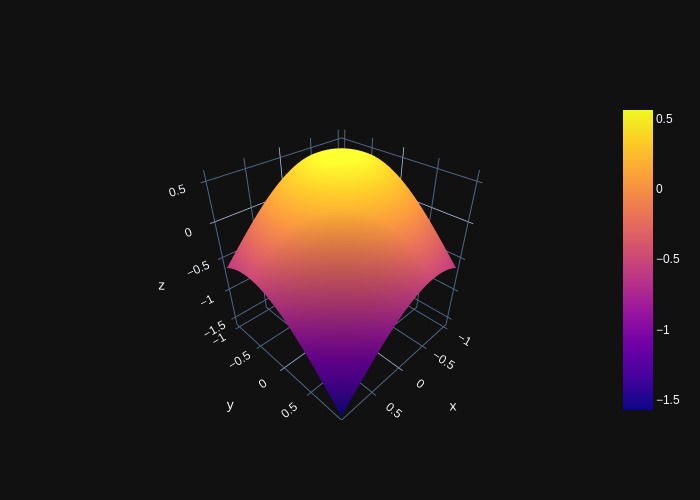

In [5]:
fig = go.Figure(data=[go.Surface(x=X, y=Y, z=np.array([cost(c, d_1) for c in coords]).reshape(100, 100))])
fig.show()

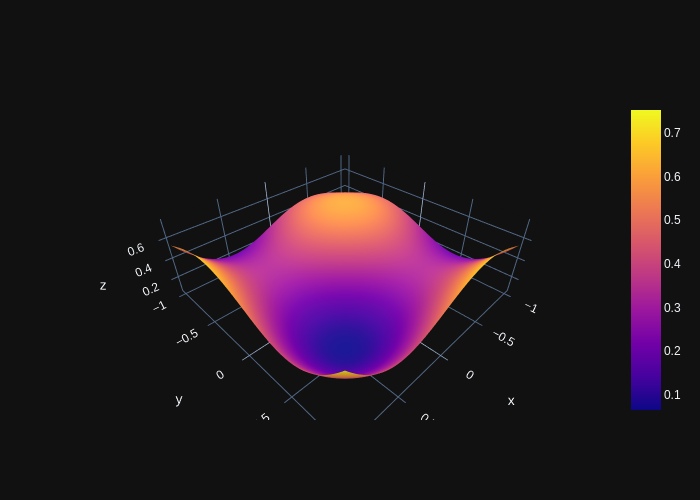

In [6]:
fig = go.Figure(data=[go.Surface(x=X, y=Y, z=np.array([cost(c, d_2) for c in coords]).reshape(100, 100))])
fig.show()

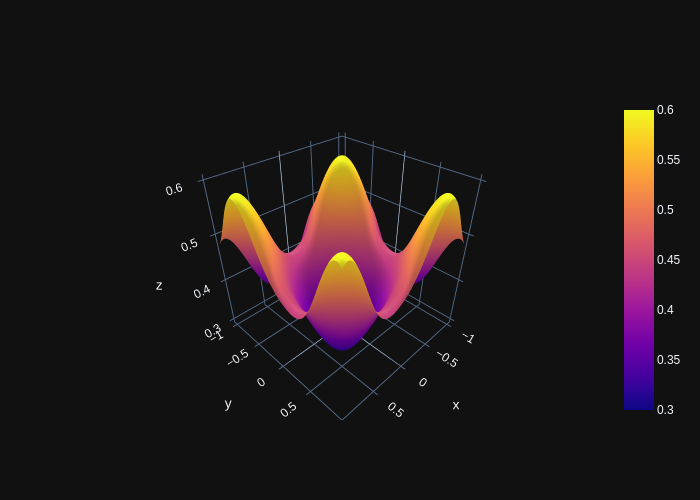

In [7]:
fig = go.Figure(data=[go.Surface(x=X, y=Y, z=np.array([cost(c, d_3) for c in coords]).reshape(100, 100))])
fig.show()

## Defining a cost function

In *parallel mode*, the cost function is not defined as in the sequential modes:
- its first argument should be a `josiann.parallel.ParallelArgument` object
- it can have optional positional arguments to receive constant parameters
- it should not return anything.

The `josiann.parallel.ParallelArgument` object tells the function what needs to be computed at a given iteration
 of the SA algorithm. Because position vectors evolve independently, the number of requested function evaluations can be
different for each parallel problem. Position vectors and the number of function evaluations can be obtained using
the `ParallelArgument.positions` and `ParallelArgument.nb_evaluations`
attributes.
Additional parallel arguments are given by the `ParallelArgument.args` attribute.

A formatted list of position vectors and associated parallel arguments can be obtained with the convenience attribute
`ParallelArgument.where_evaluations`.

In [8]:
def _cost(x: npt.NDArray[np.float64], d: npt.NDArray[np.float64]) -> npt.NDArray[np.float64]:
    return 0.6 + np.sum(
        np.sin(1 - 16 / 15 * x) ** (d + 1)
        - 1 / 50 * np.sin(4 - 64 / 15 * x) ** d
        - np.sin(1 - 16 / 15 * x) ** d,
        axis=1
    )

def paralell_cost_function(args: jo.parallel.ParallelArgument) -> None:
    x, d = args.where_evaluations
    args.result = _cost(x, d)

In this example, we will have 3 parallel problems in parallel, each obtained with different values of d (0, 1, 2).
At some given iteration of the SA algorithm, we will thus have 3 different position vectors (x_1, x_2 and x_3)
each requiring different numbers of function evaluations (n_1, n_2, n_3).

The `josiann.parallel.ParallelArgument` will thus contain:

- positions: a matrix (x_1, x_2, x_3)
- nb_evaluations: a list (n_1, n_2, n_3)
- args: a list (0, 1, 2)

The attribute *where_evaluations* will give:

```python
[
    (x_1, 0),
    ...,                # repeated n_1 times
    (x_1, 0),

    (x_2, 1),
    ...,                # repeated n_2 times
    (x_2, 1),

    (x_3, 2),
    ...,                # repeated n_3 times
    (x_3, 2)
]
```

Finally, the result of the function evaluations must not be returned but rather stored in the
`ParallelArgument` object by assigning it to the `ParallelArgument.result` attribute. Verification code will be
triggered to make sure the correct number of costs were computed.

## Putting it all together

We are now ready to run *Josiann* in parallel mode. For that, we'll need a move function able to generated multiple
position vectors, such as `josiann.parallel.ParallelSetStep`.

We will call the `josiann.parallel.psa()` algorithm, which expects for n parallel problems:
- a parallel cost function
- n initial position vectors
- an optional list of parallel arguments (arrays of length n)
- optional constant arguments, with the same value for each parallel function

In [9]:
res = jo.parallel.psa(paralell_cost_function,
                      x0=np.array([[0, 0], [0, 0], [0, 0]]),
                      parallel_args=[np.array([0, 1, 2])],
                      bounds=[(-1, 1), (-1, 1)],
                      moves=jo.parallel.ParallelSetStep(position_set=[np.linspace(-1, 1, 21),
                                                                      np.linspace(-1, 1, 21)]),
                      max_measures=1,
                      max_iter=2000,
                      backup=True,
                      seed=42)

  0%|          | 0/2000 [00:00<?, ?iteration/s]

The parallel SA algorithm converged on one position vector per problem, which can be obtained with

In [10]:
res.trace.positions.get_best().x

array([[1. , 1. ],
       [0.5, 0.5],
       [0.3, 0.3]])

From the search space given to the move function, those are the closest values to the true solutions
([1, 1], [0.47, 0.47] and [0.31, 0.31]).

  0%|          | 0/3 [00:00<?, ?it/s]

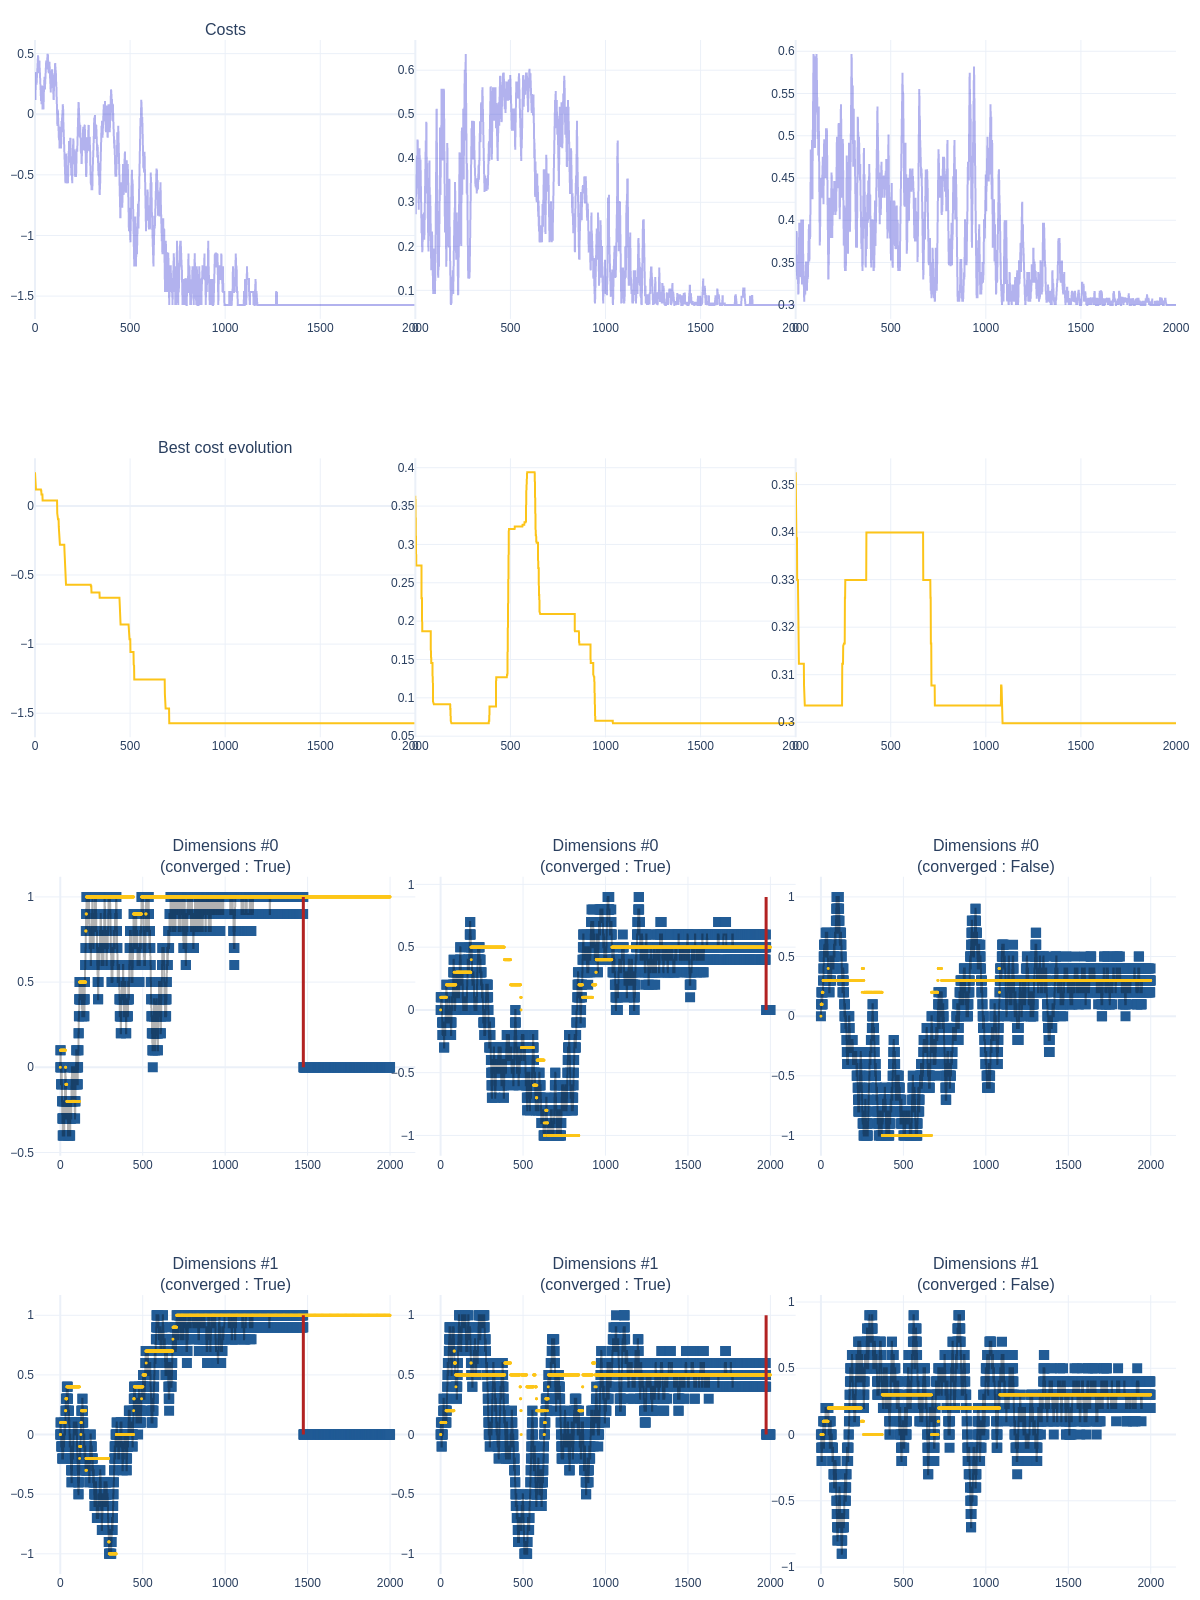

In [11]:
res.trace.plot_positions()

The plot of positions now has 3 columns, one for each parallel problem.
Red vertical lines shows the iteration at which a particular problem has converged: problem #1 converged first
(iteration 1474), then problem #2 (iteration 1974) and problem #3 ran until the end.

As before, the trace of accepted positions is shown in grey. Blue squares show attempted moves (both accepted and
refused) and yellow dots show the best found positions as iterations progress.
